In [1]:
import pandas as pd
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import sklearn
import numpy as np

In [2]:
# Kaggle download
# !kaggle competitions download -c playground-series-s5e10
# !unzip ./playground-series-s5e10.zip -d ./data/
# !rm playground-series-s5e10.zip


In [3]:
# see data 
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_sub = pd.read_csv('./data/sample_submission.csv')


In [4]:
df_train.shape

(517754, 14)

In [5]:
df_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
df_train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [7]:
df_train.isna().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

# Adding Features from the high error examples in v1

In [8]:
df_train['weather_lighting'] = df_train['weather'] + '_' + df_train['lighting']

<Figure size 1000x600 with 0 Axes>

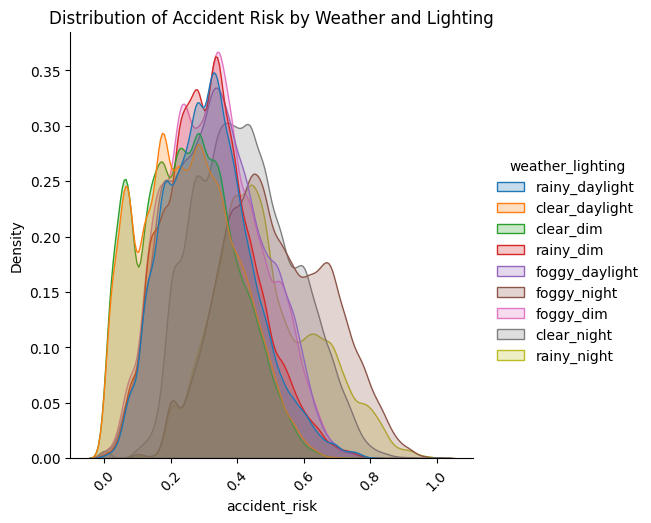

In [9]:
plt.figure(figsize=(10, 6))
sns.displot(data=df_train, x='accident_risk', hue='weather_lighting', kind='kde', fill=True)
plt.title(f'Distribution of Accident Risk by Weather and Lighting')
plt.xticks(rotation=45)
plt.show()

In [10]:
df_train['speed_limit_high'] = df_train['speed_limit'] > 50


<Figure size 1000x600 with 0 Axes>

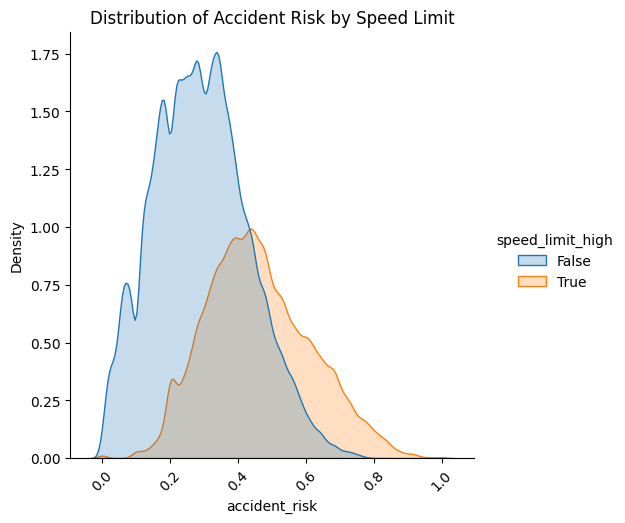

In [11]:
plt.figure(figsize=(10, 6))
sns.displot(data=df_train, x='accident_risk', hue='speed_limit_high', kind='kde', fill=True)
plt.title(f'Distribution of Accident Risk by Speed Limit')
plt.xticks(rotation=45)
plt.show()

In [12]:
df_train['accidents_high'] = df_train['num_reported_accidents'] > 2


<Figure size 1000x600 with 0 Axes>

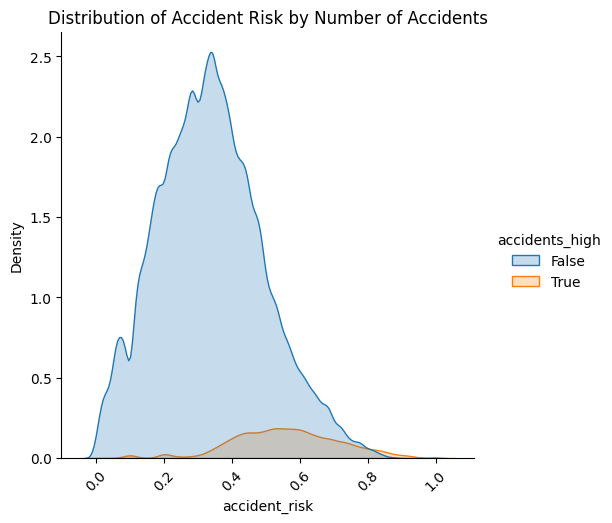

In [14]:
plt.figure(figsize=(10, 6))
sns.displot(data=df_train, x='accident_risk', hue='accidents_high', kind='kde', fill=True)
plt.title(f'Distribution of Accident Risk by Number of Accidents')
plt.xticks(rotation=45)
plt.show()

# Improved regressor from v1


In [18]:
from catboost import cv, Pool
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor

In [20]:
selected_features = [
    "curvature",
    "speed_limit",
    "lighting",
    "weather",
    "num_reported_accidents",
    "holiday",
    "road_type",
] + [
    "weather_lighting",
    "accidents_high",
    "speed_limit_high",
]  # selected features from EDA
cat_cols = [
    "lighting",
    "weather",
    "holiday",
    "road_type",
    "weather_lighting",
    "accidents_high",
    "speed_limit_high",
]

In [29]:
cat_boost_model = CatBoostRegressor(cat_features=cat_cols, verbose=0, random_seed=42, loss_function='RMSE')
result = cat_boost_model.fit(
    df_train[selected_features],
    df_train['accident_risk'],
    eval_set=Pool(df_train[selected_features], df_train['accident_risk'], cat_features=cat_cols),
    use_best_model=True,
    plot=True,
).get_best_score()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
result

{'learn': {'RMSE': 0.055859014802719244},
 'validation': {'RMSE': 0.05590621358698061}}

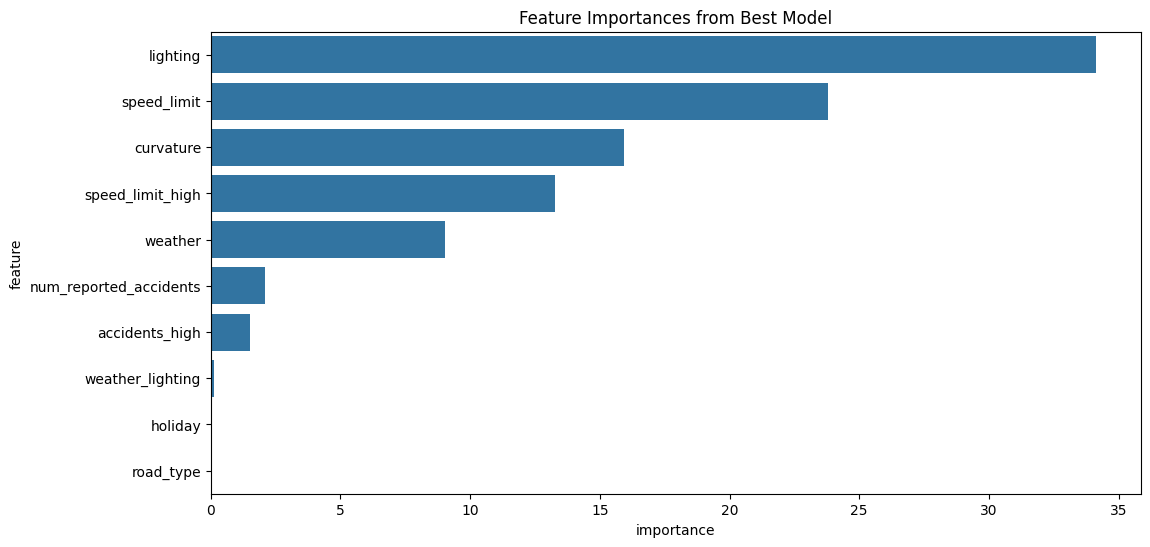

In [ ]:
# Feature importance
feature_names = cat_boost_model.feature_names_
importances = cat_boost_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importances from Best Model')
plt.show()

# Fitting on all and make prediction

In [31]:
from sklearn.metrics import root_mean_squared_error

best_model = cat_boost_model
best_model.fit(df_train[selected_features], df_train['accident_risk'], cat_features=cat_cols, verbose=0)
pred_all = best_model.predict(df_train[selected_features])
rmse = root_mean_squared_error(pred_all, df_train['accident_risk']) # validation
print(f'RMSE on all dataset: {rmse}')

RMSE on all dataset: 0.055940405333414614


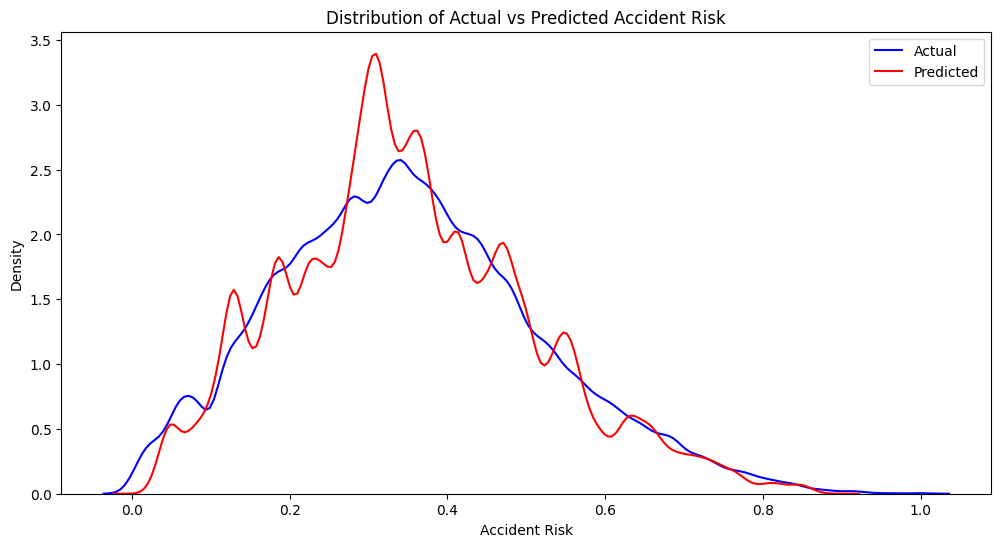

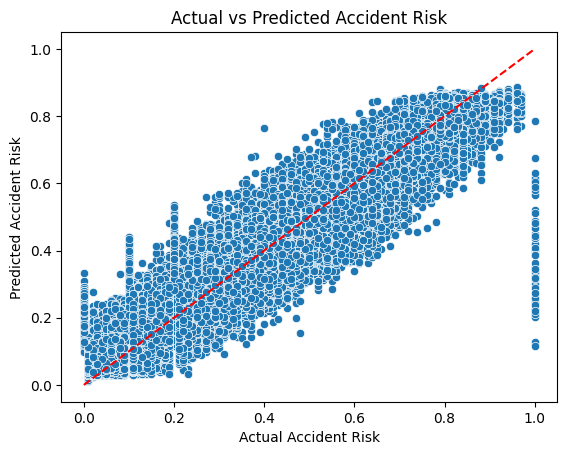

In [32]:
## Compare distribution of prediction and actual

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(df_train['accident_risk'], label='Actual', color='blue')
sns.kdeplot(pred_all, label='Predicted', color='red')
plt.title('Distribution of Actual vs Predicted Accident Risk')
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.legend()
plt.show()


# compare prediction and actual
sns.scatterplot(x=df_train['accident_risk'], y=pred_all)
plt.xlabel('Actual Accident Risk')
plt.ylabel('Predicted Accident Risk')
# add diagonal line y=x
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Actual vs Predicted Accident Risk')
plt.show()


In [39]:
# samples where accident_risk is 1
sure_accidents = df_train[df_train['accident_risk'] == 1]

# Submission 

In [ ]:
df_test['weather_lighting'] = df_test['weather'] + '_' + df_test['lighting']
df_test['speed_limit_high'] = df_test['speed_limit'] > 50
df_test['accidents_high'] = df_test['num_reported_accidents'] > 2

In [ ]:
# # set prediction to 1 if the categorical features match sure_accidents, not using loop

# def predict_accident_risk(row):
#     for _, sure_row in sure_accidents.iterrows():
#         if all(row[cat_col] == sure_row[cat_col] for cat_col in cat_cols):
#             return 1.0
#     return best_model.predict(row[selected_features].values.reshape(1, -1))[0]

In [45]:

# generate submission file
pred_test = best_model.predict(df_test[selected_features])
# fixed_predictions = df_test.apply(predict_accident_risk, axis=1)
submission = pd.DataFrame({'id': df_test['id'],
                           'accident_risk': pred_test})
submission.head()


,id,accident_risk
0,517754,0.295794
1,517755,0.121653
2,517756,0.190192
3,517757,0.331323
4,517758,0.401586


In [46]:
submission.to_csv('submission.csv', index=False)